# Monte Carlo estimation of Sensitivities in Finance
## MATH-414 Stochastic Simulation project
Authors : Charles Gendreau - Eliott Van Dieren

Professor : Prof. Fabio Nobile

Teaching Assistant : Sundar Ganesh

In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [107]:
# Utility functions

def simul_S_T(params:list,n:int,W_T : np.array) -> np.array:
    """
    Returns a numpy array of size n with prices of the underlying at maturity
    
    Args :
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
        - n : number of prices (int)
    Returns :
        - numpy array of S_T
    """
    T : float = params[0]; S_0 : float = params[1]
    r : float = params[2]; sig : float = params[3]
    #W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(T),size=n)
    return S_0*np.exp((r-0.5*sig**2)*T+sig*W_T)


def CMC_estimator(func,X:np.array,params:list) -> list:
    """
    Crude Monte-Carlo estimator of E[func(X)]
    
    args:
        - func : function from R^N to R^N where N = length of X
        - X : numpy array
    returns : 
        - Crude Monte-Carlo estimator of the mean
        - Standard deviation (for CI purposes)    
    """
    return np.array([np.mean(func(X,params)),np.std(func(X,params))])

def finite_difference(func,params:list,dtheta:float,derivative:str, n:int) -> float:
    """
    Finite difference method to compute the derivative of I := E[func(S_T)] wrt theta
    
    I is computed with the CMC_estimator function which takes func and S_T as argument
    
    args:
        - func : function from R^N to R^N which takes S_T as parameter (payoff function)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - dtheta : small delta of theta to compute the finite difference (float)
        - derivative : either "delta", "vega" or "gamma"
        - n : number of simulations for Monte-Carlo
        
    returns : the estimated value of dI/dtheta by finite difference method and its standard deviation
    
    """
    
    if derivative not in ["delta","vega","gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
    
    idx_deriv : int = 3 if derivative == "vega"  else 1 # Useful to know which parameter we have to modify
    
    # Definition of new parameters
    params_pos : list = params.copy(); params_neg : list = params.copy()
    params_pos[idx_deriv] += dtheta ; params_neg[idx_deriv] -= dtheta
    
    # Generation of Brownian motion
    W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
    
    diff_f = lambda x,p : func(x[0],p[0])-func(x[1],p[1]) # x = [S_T_pos,neg], p = [params_pos,neg]
    diff_f_2 = lambda x,p : func(x[0],p[0])-2*func(x[2],p[2])+func(x[1],p[1]) # x = [S_T_pos,neg,S_T], p = [params_pos,neg,params] 
    
    # Generation of payoff estimates
    if derivative == "gamma": # Due to different equation for second order derivative estimates
        S_T_tot = [simul_S_T(params_pos,n,W_T),simul_S_T(params_neg,n,W_T),simul_S_T(params,n,W_T)]
        params_tot = [params_pos,params_neg,params]
        mu_std = CMC_estimator(diff_f_2,S_T_tot,params_tot) 
        return mu_std/dtheta**2
    else: # For delta and vega
        S_T_tot = [simul_S_T(params_pos,n,W_T),simul_S_T(params_neg,n,W_T)]
        params_tot = [params_pos,params_neg]
        mu_std = CMC_estimator(diff_f,S_T_tot,params_tot)
        return 0.5*mu_std/dtheta
    
def pathwise_deriv(deriv_func, params:list,dSdtheta : float,derivative:str, n:int) -> float:
    """
    Pathwise derivative method to compute the derivative of I := E[func(S_T)] wrt theta
        
    args:
        - deriv_func : function from R^N to R^N which takes S_T as parameter (derivative of payoff function)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - dSdtheta : function of derivative of S_T wrt theta (takes parameters as input)
        - derivative : either "delta", "vega" or "gamma"
        - n : number of simulations for Monte-Carlo
        
    returns : the estimated value of dI/dtheta by pathwise derivative and its standard deviation
    
    """
    
    if derivative not in ["delta","vega","gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
        
    W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
    S_T : np.array = simul_S_T(params,n,W_T)
    
    path_deriv = lambda x,params : deriv_func(x,params)*dSdtheta(params)
    
    return CMC_estimator(deriv_func,S_T,params)

## 3. Application to option pricing

### 3.1 European Call Option

In [109]:
# Parameters
T : float = 1
S_0 : float = 100
K : float = 120
r : float = 0.05
sig : float = 0.25
params : list = [T,S_0,r,sig,K]
dtheta : float = 1e-5

greeks = ["delta","vega","gamma"]

# Payoff function for European Call Option
C_payoff = lambda x,p: np.exp(-p[2]*p[0])*np.maximum(x-p[4],np.zeros(len(x)))

# Derivative function for European Call Option
# todo

In [110]:
n_elem : np.array = np.arange(10**3,10**5+1000,1000)

# Finite difference method
finite_methods_dict = {}
for greek in greeks:
    finite_methods_dict[greek] = np.array([finite_difference(C_payoff,params,dtheta,greek, n) for idx,n in enumerate(n_elem)])

Explications Finite difference method:

Pour delta et vega : $\frac{\partial I}{\partial \theta} \approx \frac{I(\theta+\Delta\theta)-I(\theta-\Delta\theta)}{2 \Delta\theta} = \mathbb{E}[\frac{f(S_T^{\theta+\Delta\theta})-f(S_T^{\theta-\Delta\theta})}{(2 \Delta\theta)}]$ that was estimated with the Crude-Monte Carlo estimator by distributing the expectation on both functions. 


For the variance of $\frac{\partial I}{\partial \theta}$, we get : $Var(\frac{f(S_T^{\theta+\Delta\theta})-f(S_T^{\theta-\Delta\theta})}{(2 \Delta\theta)}) = \frac{1}{4(\Delta\theta)^2}Var(f(S_T^{\theta+\Delta\theta})-f(S_T^{\theta-\Delta\theta})) = \frac{1}{4(\Delta\theta)^2}[Var(f(S_T^{\theta+\Delta\theta})) + Var(f(S_T^{\theta-\Delta\theta})) - 2Cov(f(S_T^{\theta+\Delta\theta}),f(S_T^{\theta-\Delta\theta})]$.

Estimated delta value with biggest N:  0.344879496450566
real delta value :  0.3676359083901262
Estimated gamma value with biggest N:  -2.7977922712960063e-07
real gamma value :  0.01398824374254948
Estimated vega value with biggest N:  36.839878774765936
real vega value :  34.9706093563737


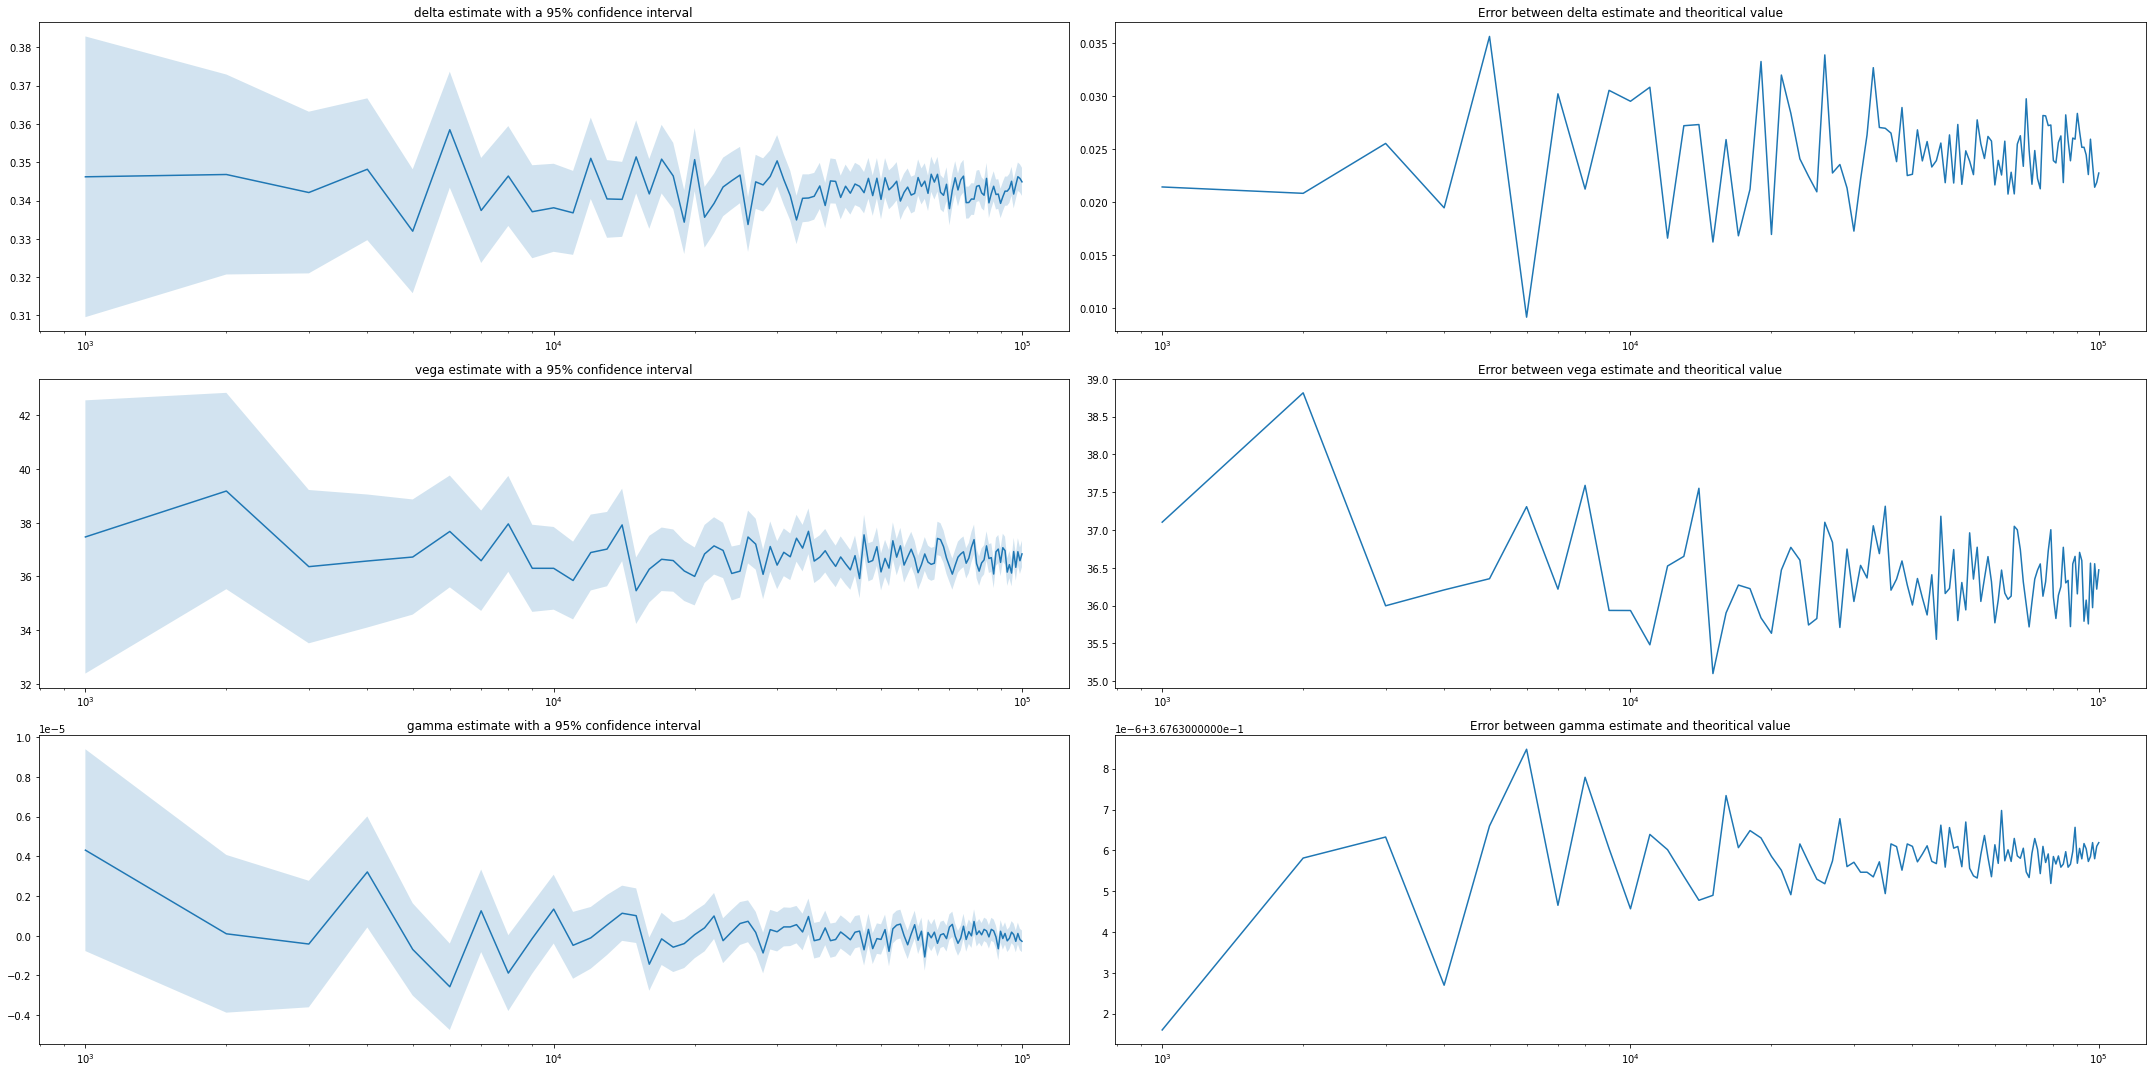

In [111]:
# Results Finite difference method

d1 : float = (np.log(S_0/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))

print("Estimated delta value with biggest N: ", finite_methods_dict["delta"][-1,0])
print("real delta value : ",st.norm.pdf(d1))

print("Estimated gamma value with biggest N: ", finite_methods_dict["gamma"][-1,0])
print("real gamma value : ",np.exp(-r*T)*st.norm.pdf(d1)/(sig*S_0*np.sqrt(T)))

print("Estimated vega value with biggest N: ", finite_methods_dict["vega"][-1,0])
print("real vega value : ",np.exp(-r*T)*S_0*np.sqrt(T)*st.norm.pdf(d1))

fig, ax = plt.subplots(3,2,figsize=(30,15))

for idx,greek in enumerate(greeks):
    ax[idx,0].plot(n_elem,finite_methods_dict[greek][:,0],label=greek)
    ax[idx,0].fill_between(n_elem, finite_methods_dict[greek][:,0] - 1.96*finite_methods_dict[greek][:,1]/np.sqrt(n_elem), 
                                 finite_methods_dict[greek][:,0] + 1.96*finite_methods_dict[greek][:,1]/np.sqrt(n_elem),alpha=0.2)
    ax[idx,1].plot(n_elem,np.abs(st.norm.pdf(d1)-finite_methods_dict[greek][:,0]))
    ax[idx,0].set_title(f"{greek} estimate with a 95% confidence interval")
    ax[idx,1].set_title(f"Error between {greek} estimate and theoritical value")
    ax[idx,0].set_xscale("log")
    ax[idx,1].set_xscale("log")

fig.tight_layout()

Comments :

Le gamma blow up totalement

Quelle valeur de $\Delta \theta$ choisir?

Todo : analyser l'erreur selon $\Delta \theta$ et discuter des iid sampling (j'ai testé, et ça devient nul à chier)

In [113]:
# Pathwise derivative
# Todo : dériver le payoff et le modèle BS pour S_T
pathwise_dict = {}
for greek in greeks:
    pathwise_dict[greek] = np.array([pathwise_deriv(deriv_C_payoff,params,dSdtheta,greek, n) for idx,n in enumerate(n_elem)])

NameError: name 'deriv_C_payoff' is not defined